# MammoScan AI: 07 - Local Fine-Tuning of the Transfer Learning Model

## 🎯 Goal
This notebook documents the final stage of our modeling experiments: **advanced fine-tuning**. We will load our previously trained transfer learning model, un-freeze the top layers of the EfficientNet base, and re-train it with on-the-fly data augmentation and a very low learning rate.

**⚠️ Performance Warning:** This process is computationally intensive. Running this on a local CPU will be **very slow**. It is recommended for verifying the code works, but for a full training run, the Google Colab version is preferred.

In [2]:
# --- Core Libraries ---
import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# --- Path Setup ---
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# --- Custom Modules ---
# Import our model builder for robust loading
from ml.src.model import create_transfer_model

## 📥 Step 1: Data & Constants

We start by ensuring our processed data is available locally with `dvc pull`. We then define our paths and hyperparameters, including the `EarlyStopping` callback to automatically find the best training duration.

In [3]:
# Ensure the processed data is present locally
# !dvc pull data/processed.dvc

In [4]:
# --- Constants ---
PROCESSED_DATA_DIR = os.path.join(project_root, 'data', 'processed')
# Path to the model we trained in the last notebook
BASE_MODEL_PATH = os.path.join(project_root, 'models', 'checkpoints', 'transfer_learning_model.keras')
# Path to save our new, fine-tuned model
FINE_TUNED_MODEL_PATH = os.path.join(project_root, 'models', 'checkpoints', 'fine_tuned_model.keras')

# --- Training Hyperparameters ---
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 50 # Early stopping will find the best number

# --- Callbacks ---
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

## 🚚 Step 2: Data Preparation with Augmentation

We load our datasets and apply on-the-fly augmentation to the training set. The validation set remains un-augmented for a fair evaluation. We also apply the required EfficientNet preprocessing to both datasets.

In [5]:
# --- On-the-fly Data Augmentation ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

# --- Data Loading ---
print("Loading datasets...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(PROCESSED_DATA_DIR, 'train'),
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(PROCESSED_DATA_DIR, 'val'),
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# Apply augmentation and preprocessing
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y))
val_dataset = val_dataset.map(lambda x, y: (preprocess_input(x), y))

print("✅ Datasets loaded. Augmentation and preprocessing applied.")

Loading datasets...
Found 521 files belonging to 2 classes.
Found 112 files belonging to 2 classes.


2025-09-03 13:36:46.476121: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-03 13:36:46.479908: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


✅ Datasets loaded. Augmentation and preprocessing applied.


## 🛠️ Step 3: Un-Freezing and Re-Compiling the Model

This is the core of fine-tuning. We load our previously trained model, "un-freeze" the top layers of the EfficientNet base, and then re-compile the entire model with a very low learning rate to make careful, precise adjustments.

In [7]:
# --- Load the base model ---
# Note: If this fails due to version mismatches, use the create_model + load_weights method.
print(f"Loading base model from: {BASE_MODEL_PATH}")
model = tf.keras.models.load_model(BASE_MODEL_PATH)

# --- Un-freeze the base model's top layers ---
base_model = model.layers[1]
base_model.trainable = True

# Fine-tune the top third of the layers
fine_tune_at = len(base_model.layers) // 3 * 2
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# --- Re-compile the model with a very low learning rate ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # 10x smaller learning rate
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)
print("✅ Model re-compiled for fine-tuning.")
model.summary()

# --- Calculate Class Weights ---
print("\nCalculating class weights...")
labels = np.concatenate([y for x, y in train_dataset], axis=0)
neg, pos = np.bincount(labels.astype(int).flatten())
total = neg + pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}
print(f"Calculated class weights: {class_weights}")

Loading base model from: /home/mr-rey/Joseph/Projects/Python/mammoscan-AI/models/checkpoints/transfer_learning_model.keras
✅ Model re-compiled for fine-tuning.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 3,232,509 (12.33 MB)

 Non-trainable params: 818,343 (3.12 MB)


Calculating class weights...
Calculated class weights: {0: 2.9942528735632186, 1: 0.6002304147465438}


2025-09-03 13:40:19.868507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 🏃‍♂️ Step 4: Fine-Tune and Save

Now we run the final training process. The model will now update the weights in both our custom head and the un-frozen layers of the EfficientNet base, hopefully leading to a significant performance improvement.

In [ ]:
# --- Fine-Tune the Model ---
print("\n--- Starting model fine-tuning ---")
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[early_stopping]
)
print("--- Model fine-tuning finished ---\n")

# --- Save the Final Model ---
# Ensure the save directory exists
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
print(f"Saving fine-tuned model to {FINE_TUNED_MODEL_PATH}...")
model.save(FINE_TUNED_MODEL_PATH)
print("✅ Fine-tuned model saved successfully!")

# MammoScan AI: 07 - Local Evaluation of the Fine-Tuned Model

## 🎯 Goal
This notebook provides the final, unbiased evaluation of our fine-tuned transfer learning model on a local machine.

**⚠️ Performance Warning:** Running model predictions on a CPU can be slow.

In [8]:
# --- Core Libraries ---
import os
import sys
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- Path Setup ---
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# --- Custom Modules ---
from ml.src.model import create_transfer_model

# --- Constants ---
PROCESSED_DATA_DIR = os.path.join(project_root, 'data', 'processed')
MODEL_PATH = os.path.join(project_root, 'models', 'checkpoints', 'fine_tuned_model.keras')
REPORT_PATH = os.path.join(project_root, 'reports', 'fine_tuned_metrics.json')

# Hyperparameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [9]:
# Ensure the processed data is present locally from DVC
# !dvc pull data/processed.dvc

# 1. Re-create the model architecture from our src module
print("Re-creating transfer learning model architecture...")
model = create_transfer_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# 2. Compile the model to prepare it for evaluation
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

# 3. Load the fine-tuned weights from our local checkpoints
print(f"Loading model weights from: {MODEL_PATH}")
model.load_weights(MODEL_PATH)

# 4. Load and preprocess the test dataset
print("Loading test dataset...")
test_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(PROCESSED_DATA_DIR, 'test'),
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False
)

preprocess_input = tf.keras.applications.efficientnet.preprocess_input
test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y))

class_names = ['Cancer', 'Non-Cancer'] # Correct class order
print(f"Classes: {class_names}")

Re-creating transfer learning model architecture...
Loading model weights from: /home/mr-rey/Joseph/Projects/Python/mammoscan-AI/models/checkpoints/fine_tuned_model.keras
Loading test dataset...
Found 112 files belonging to 2 classes.
Classes: ['Cancer', 'Non-Cancer']


/home/mr-rey/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 148 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Evaluating fine-tuned model on the test set...
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8856 - loss: 0.2777 - recall: 0.9888

--- Test Set Evaluation (Fine-Tuned Model) ---
Loss: 0.2100
Accuracy: 0.9196
Recall: 0.9785


2025-09-03 13:54:31.156705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step

--- Classification Report ---
              precision    recall  f1-score   support

      Cancer       0.86      0.63      0.73        19
  Non-Cancer       0.93      0.98      0.95        93

    accuracy                           0.92       112
   macro avg       0.89      0.81      0.84       112
weighted avg       0.92      0.92      0.91       112


--- Confusion Matrix ---


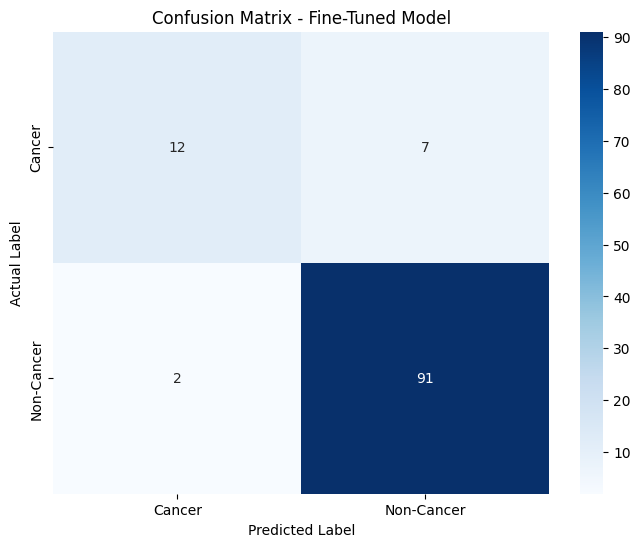


✅ Final metrics saved successfully to: /home/mr-rey/Joseph/Projects/Python/mammoscan-AI/reports/fine_tuned_metrics.json


In [10]:
# --- Run Evaluation ---
print("\nEvaluating fine-tuned model on the test set...")
results = model.evaluate(test_dataset)
print("\n--- Test Set Evaluation (Fine-Tuned Model) ---")
print(f"Loss: {results[0]:.4f}")
print(f"Accuracy: {results[1]:.4f}")
print(f"Recall: {results[2]:.4f}")

# --- Generate Detailed Reports ---
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
predictions = model.predict(test_dataset)
predicted_labels = (predictions > 0.5).astype(int)

print("\n--- Classification Report ---")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Fine-Tuned Model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# --- Save Metrics to Local File ---
final_metrics = {
    'loss': results[0],
    'accuracy': results[1],
    'recall': results[2],
    'classification_report': classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)
}

# Ensure the reports directory exists
report_dir = os.path.dirname(REPORT_PATH)
os.makedirs(report_dir, exist_ok=True)
    
with open(REPORT_PATH, 'w') as f:
    json.dump(final_metrics, f, indent=4)

print(f"\n✅ Final metrics saved successfully to: {REPORT_PATH}")